<a href="https://colab.research.google.com/github/br3nburk/adleobb/blob/main/graded_assignment1_bb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

Work through the assignment 1 notebook, and use this notebook to provide your answers. 

To submit the assignment, you will need to use GitHub.

Using your own GitHub profile:

- Create a private repository called adleoxyz, where the xyz part is replaced with your initials. Note the lower case and the formatting. Please maintain that. If you have only 2 initials or more than 3, please use them.
- Add all three instructors as collaborators to your private repository

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment1_xyz.ipynb, with xyz again replaced by your initials.

# Answers to the theoretical questions

Please provide your answers to questions 1-4 here

**Answer to Q1)**

**Part a - For greyscale image**

First layer learnable parameters: 10,001,000

Second layer learnable parameters: 10,010

Work:
First layer = pixels x (input x hidden) + h_bias
(100x100) x (1x1000) + 1000 = 10,001,000

Second layer = (hidden x output) + o_bias
(1000x10) + 10 = 10,010

**Part b - For multi-spectral image**

First layer learnable parameters: 70,001,000

Second layer learnable parameters: 10,010

Work:
First layer = (bands x pixels) x (input x hidden) + h_bias
(7x100x100) x (1x1000) + 1000 = 70,001,000

Second layer = (hidden x output) + o_bias
(1000x10) + 10 = 10,010


**Part c - tensor shapes**

For multi-spectral image

- First layer weight and bias shapes that transform the input to the hidden features:
For m rows and n columns with notation m x n:

Weights: (70,000 x 1000)

Bias: (1000 x 1)

- Second layer weight and bias shapes that map from the hidden features to output classes:

Weights: (1000 x 10)

Bias: (10 x 1)

Work:
For weights assuming format Y = WX + B:
(Nodes of first layer x Nodes of second layer)
For biases:
same dimensions as forward layer

**<font color='red'>Complete 10/10 points on Q1</font>**


**Answer to Q2**

A non-linear activation function allows the stacking of multiple layers of neurons to create a DNN. Backpropagation cannot occur with a linear activation function. At a conceptual level, the purpose of the activation function is to introduce non-linearity to the network, because most processes being modeled/classified by DNN are by nature complex and unlikely to behave according to simple linear patterns. Without a non-linear activation function in the network, even a neural network of 1000 layers would behave like a single-layer perceptron, because the output can only be a linear transformation of the input.

**<font color='red'>5/5 points on Q2</font>**

**Answer to Q3**

Why is ReLU preferred in modern architectures over sigmoid activation function? Please use the graph of these functions and their derivitives in your reasoning.

The ReLU activation function has several advantages over sigmoid. First, ReLU is computationally more efficient than sigmoid since it does not require an expensive operation such as exponentials; they are easy to optimize because they are so similar to linear units, except they output 0 across half their domain. Additionally, ReLU does not suffer from the vanishing gradient problem like sigmoid does. The graph of the ReLU function and its derivative shows that the slope of the ReLU function is either 0 or 1, whereas the sigmoid function has a continuously decreasing slope as the x values increase. This means that the gradient of the ReLU function remains constant, while the gradient of the sigmoid function diminishes as the x value increases. This makes it difficult for the weights to update in the sigmoid function, leading to the vanishing gradient problem.

**<font color='red'>Complete 5/5 points on Q3</font>**

**Answer to Q4**

Shuffling affects updates of the model parameters (learning). During testing and validation, you are not learning and it shouldn't make a difference shuffling the test or validation data, unless the testing or validation metric depends on the order of samples. Shuffling is important during training, because without it, the arbitrary order of the dataset (assuming it is non-ordinal) will bias results. We want to minimize our loss function; By shuffling data before batch selection each epoch, we avoid the problem of non-convexity: the loss surface of an unshuffled dataset will be unchanged each epoch, making the gradient descent algorithm susceptible to becoming stuck in a local minima, never reaching the minimum value of a loss function. Shuffling combined with mini-batching helps the solver "bounce" out of local minima.

**<font color='red'>5/5 points on Q4</font>**

**<font color='red'>In mini-batch training with gradient decent instead of the whole dataset we feed the network only a subset where the size is decided by a batch size and the items through a sampling strategy. From the probabilistic view, We want each mini-batch to be a representative of our whole dataset which can be achieved best through a random sampling strategy. From the optimization viewpoint, we want to find the best possible minima in reasonable time on a non-convex surface. The problem is there might be many local minimums in our surface and we might get stuck in one of those minima while a deeper/lower/better solution may lie nearby on the surface. This is likely to occur if the mini-batch input is unchanged, making the loss surface static for that mini-batch over all training epochs. Shuffling changes the mini-batches for each epoch. This changes the loss surface from iteration to interation and between epochs. The effect is that now with the surface changes local minias will change too which gives the optimzation algorithm to bounce out of a possibly bad local minimum. As we don't do optimization on the validation dataset and because of the monitoring rule of the validation curve we prefer to keep the mini-batches and consequently the loss surface fixed to better diagnose our problems in the learning process.</font>**

**<font color='red'>Global minimum is an ideal that we never reach at least not with much more complex methods using higher order drivitives. We look for a good local minima and by good I mean the one with a strong generalization power.</font>**

# Coding Assignment

Follow the instructions below to complete your coding assignment. 

Run the code below unchanged, unless otherwise indicated. 

## Static code 1

Run unchanged

Mount drive and run imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

## Variables to set

- Model save path: Modify 'save_dir' to the path to your already downloaded MNIST dataset (from the main notebook).

In [ ]:
save_dir = "/content/gdrive/MyDrive/BB_ADLEO/A1"

## Static code 2

### Transforms and loads (Steps 1.1-1.5)

Necessary transforms - run unchanged


In [ ]:
mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

train_transforms = transforms.Compose(
    [transforms.RandomRotation(5, fill=(0,)),
     transforms.RandomCrop(28, padding=2),
     transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

Load and split

In [ ]:
train_data = datasets.MNIST(root=save_dir,
                            train=True,
                            download=False,
                            transform=train_transforms)

test_data = datasets.MNIST(root=save_dir,
                           train=False,
                           download=False,
                           transform=test_transforms)

train_ratio = 0.9

n_train_examples = int(len(train_data) * train_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,[n_train_examples, 
                                                       n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Make iterable

In [ ]:
# Don't change this cell

#train_bsize = 54 # hyper-parameter you can change

train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=train_bsize)

valid_loader = data.DataLoader(valid_data,
                               shuffle=False,
                               batch_size=train_bsize)

test_loader = data.DataLoader(test_data,
                              shuffle=False,
                              batch_size=train_bsize)

### Metrics and some other necessary functions

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = Variable(x).to(device)
        y = Variable(y).to(device)

        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Disable automatic differentiation as we don't do optimization on eval.
    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = Variable(x).to(device)
            y = Variable(y).to(device)

            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


## Task 1: Adjust the model

Modify your MLP as required

**<font color='red'>14/15 points on coding task 1</font>**

- Need another BN and dropout for the second hidden layer.
- hidden_dim argument as a list is not implemented.

**<font color='red'>0/5 points on optional 1</font>**

In [ ]:
# Modify this cell
class MLP(nn.Module):10
    def __init__(self, in_dim, hidden_1, hidden_2, out_dim, drop_rate):
        super(MLP, self).__init__()

# Input parameters and type cast to integer:
        # in_dim = 28 * 28

        # hidden_1 = input("Enter 1st hidden layer dimensions:")
        # hidden_1 = int(hidden_1)

        # hidden_2 = input("Enter 2nd hidden layer dimensions:")
        # hidden_2 = int(hidden_2)

        # out_dim = input("Enter output layer dimensions:")
        # out_dim = int(out_dim)

        # drop_rate = input("Enter drop rate:")
        # drop_rate = float(drop_rate)


#nn.Sequential example #2
        layers=[]
        layers.append(nn.Linear(in_dim, hidden_1, bias=True)) # input_FC
        layers.append(nn.BatchNorm1d(hidden_1,))
        layers.append(nn.LeakyReLU()) # LeakyReLU_1
        layers.append(nn.Dropout(drop_rate, inplace=False)) # drop out
        
        layers.append(nn.Linear(hidden_1, hidden_2, bias=False)) # Hidden_FC
        layers.append(nn.LeakyReLU()) # LeakyReLU_2
        layers.append(nn.Linear(hidden_2, out_dim, bias=True)) # Output_FC

        self.mlp_block = nn.Sequential(*layers)

        # Ioffe Szegedy 2015 order recommendation:
        # -> FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> FC ->
        # no BN or drops from H2->O bc slowed training for simple 4 layer network
        
        # leaky ReLu specs
        # nn.LeakyReLU(negative_slope=0.01, inplace=False)
        

    def forward(self, x): #defines how forward propagation runs for training and inference


        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        y_pred = self.mlp_block(x)

        return y_pred

# GPT skeleton
        # self.fc1 = nn.Linear(in_dim, hidden_dims)
        # self.bn1 = nn.BatchNorm1d(num_features=hidden_dims)
        # self.dropout = nn.Dropout(p=0.5)
        # self.fc2 = nn.Linear(hidden_dims, num_classes)
        # self.relu = nn.LeakyReLU()
    
    # def forward(self, x):
    #     out = self.fc1(x)
    #     out = self.bn1(out)
    #     out = self.dropout(out)
    #     out = self.relu(out)
    #     out = self.fc2(out)
    #     return out
      


If you are struggling to get it working, here is a commented out version of the example model that you can run and adapt.  You might want to use some of the other 3 examples that we suggested for structuring the model class

In [ ]:
# class MLP(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(MLP, self).__init__()
        
#         self.input_fc = nn.Linear(input_dim, 250)
#         self.hidden_fc = nn.Linear(250, 100)
#         self.output_fc = nn.Linear(100, output_dim)

#     def forward(self, x):
        
#         # x is a batch of images with the shape: [batch size, height, width]
#         batch_size = x.shape[0]
        
#         # First, we have to convert the 2D tensor (H and W) in 
#         # an Mnist image, into a 1D tensor so that it can be fed into the first 
#         # Linear layer, and we do that using the view().
#         x = x.view(batch_size, -1)

#         # x is now have the shape: [batch size, (height * width)]

#         # we pass input through each layer and the activation function in order, finally 
#         # returning the output to give us our prediction for that image.
#         h_1 = F.relu(self.input_fc(x))

#         # h_1 = [batch size, 250]
#         h_2 = F.relu(self.hidden_fc(h_1))

#         # h_2 = [batch size, 100]
#         y_pred = self.output_fc(h_2)

#         # y_pred = [batch size, output dim]

#         return y_pred

Define the parameters needed to run the model

In [ ]:
in_dim = 28 * 28

hidden_1 = input("Enter 1st hidden layer dimensions:")
hidden_1 = int(hidden_1)

hidden_2 = input("Enter 2nd hidden layer dimensions:")
hidden_2 = int(hidden_2)

out_dim = input("Enter output layer dimensions:")
out_dim = int(out_dim)

drop_rate = input("Enter drop rate (0.2 is good start):")
drop_rate = float(drop_rate)

initial_lr = input("Enter SGD initial learning rate (0.001 is good start):")
initial_lr = float(initial_lr) # Hyper-parameter that you can change for optional part

num_epochs = input("Enter epochs (10 is good start):") # same as above
num_epochs = int(num_epochs)

train_bsize = input("Enter training batch size (54 is good start):") 
train_bsize = int(train_bsize)

# variables defined in model code block
# in_dim = 28 * 28
# hidden_1 =  
# hidden_2 = 
# out_dim = 10
# drop_rate =   # choose a number in the range [0,1] for your dropout 
# Look on the web and experiment yourself to find a good rate


Enter 1st hidden layer dimensions:1500
Enter 2nd hidden layer dimensions:1500
Enter output layer dimensions:10
Enter drop rate (0.2 is good start):0.2
Enter SGD initial learning rate (0.001 is good start):0.001
Enter epochs (10 is good start):5
Enter training batch size (54 is good start):54


## Task 2: Show your work

**<font color='red'>Complete 10/10 points on coding task 2</font>**

Run and print the model

In [ ]:
# Don't change this cell
#model = MLP(in_dim, hidden_1, hidden_2, out_dim, drop_rate)
model = MLP(in_dim, hidden_1, hidden_2, out_dim, drop_rate)
print(model)

MLP(
  (mlp_block): Sequential(
    (0): Linear(in_features=784, out_features=1500, bias=True)
    (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1500, out_features=1500, bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1500, out_features=10, bias=True)
  )
)


Show the number of parameters in the model

In [ ]:
# Don't change this cell
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,445,510 trainable parameters


Optimizer, loss criterion, and GPU/CPU switch

In [ ]:
# changed optimizer to sgd
optimizer = optim.SGD(model.parameters(), lr=initial_lr)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Train the model

In [ ]:
best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    #simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 32s
	Train Loss: 1.877 | Train Acc: 48.29%
	 Val. Loss: 1.217 |  Val. Acc: 76.09%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 33s
	Train Loss: 1.265 | Train Acc: 65.39%
	 Val. Loss: 0.740 |  Val. Acc: 83.73%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 31s
	Train Loss: 0.997 | Train Acc: 70.88%
	 Val. Loss: 0.571 |  Val. Acc: 86.46%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 34s
	Train Loss: 0.854 | Train Acc: 74.97%
	 Val. Loss: 0.491 |  Val. Acc: 88.19%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 33s
	Train Loss: 0.760 | Train Acc: 77.83%
	 Val. Loss: 0.439 |  Val. Acc: 89.50%


Plot the results

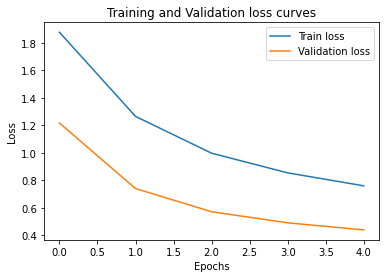

In [ ]:
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Evaluate the performance

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/186 [00:00<?, ?it/s]

Test Loss: 0.410 | Test Acc: 90.24%


Show the matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix



def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

    disp = plot_confusion_matrix(labels, pred_labels)
    disp.plot()
    plt.show()

    

    

In [ ]:
plot_confusion_matrix(labels, pred_labels)

NameError: ignored

## Optional Task 3

Use the model above and the parameters for batch size, learning rate, and dropout to evaluate model performance. Repeat using the code above from Task 2: Show your work. Provide the outputs (loss curves, performance metrics), from the best and worst results in the cells below. 

**<font color='red'>0/5 points on optional 2</font>**

### Best result

### Worst result